In [1]:
import numpy as np
import pandas as pd
from functools import partial
from scipy.optimize import minimize
from scipy.special import expit
from arch import arch_model
from matplotlib import pyplot as plt
import yfinance as yf

In [2]:
def simulate_contaminated_garch(n, mu, omega, alpha, beta, eta):
    returns = np.zeros(n)
    returns[0] = 0

    sigma2s = np.zeros(n)
    sigma2s[0] = omega

    for t in range(1, n):
        sigma2s[t] = omega + alpha * returns[t-1]**2 + beta * sigma2s[t-1]
        returns[t] = np.random.normal(mu, np.sqrt(sigma2s[t])) + float(eta * (np.random.uniform(0, 1) < 0.005))

    return returns, sigma2s

In [3]:
sp500_returns = yf.download("SPY", start="2000-01-01", end="2023-12-31")
sp500_returns = np.log(sp500_returns["Adj Close"]).diff()

[*********************100%%**********************]  1 of 1 completed


In [77]:
def es(params, returns, is_index=500):
    assert len(params) == 1
    n = len(returns)
    sigma2s = np.zeros(n)
    sigma2s[:is_index] = np.mean(returns[:is_index]**2)
    alphas = expit(params[0]) * np.ones(n)
    for t in range(is_index, n):
        sigma2s[t] = (1 - alphas[t-1]) * sigma2s[t-1] + alphas[t-1] * returns[t-1]**2
    
    return sigma2s, alphas

def stes_ae(params, returns, is_index=500):
    assert len(params) == 2
    n = len(returns)
    sigma2s = np.zeros(n)
    sigma2s[:is_index] = np.mean(returns[:is_index]**2)
    alphas = np.zeros(n)
    for t in range(is_index, n):
        features = np.array([1, abs(returns[t-1])])
        alpha = expit(params @ features)
        alphas[t-1] = alpha
        sigma2s[t] = (1 - alphas[t-1]) * sigma2s[t-1] + alphas[t-1] * returns[t-1]**2

    return sigma2s, alphas

def stes_se(params, returns, is_index=500):
    assert len(params) == 2
    n = len(returns)
    sigma2s = np.zeros(n)
    sigma2s[:is_index] = np.mean(returns[:is_index]**2)
    alphas = np.zeros(n)
    for t in range(is_index, n):
        features = np.array([1, returns[t-1]**2])
        alpha = expit(params @ features)
        alphas[t-1] = alpha
        sigma2s[t] = (1 - alphas[t-1]) * sigma2s[t-1] + alphas[t-1] * returns[t-1]**2

    return sigma2s, alphas

def stes_aese(params, returns, is_index=500):
    assert len(params) == 3
    n = len(returns)
    sigma2s = np.zeros(n)
    sigma2s[:is_index] = np.mean(returns[:is_index]**2)
    alphas = np.zeros(n)
    for t in range(is_index, n):
        features = np.array([1, abs(returns[t-1]), returns[t-1]**2])
        alpha = expit(params @ features)
        alphas[t-1] = alpha
        sigma2s[t] = (1 - alphas[t-1]) * sigma2s[t-1] + alphas[t-1] * returns[t-1]**2

    return sigma2s, alphas

def rmse(model, params, returns, is_index=500, os_index=2000):
    sigma2s, alphas = model(params, returns, is_index)
    
    sse = (returns ** 2 - sigma2s) ** 2
    is_mse = np.sqrt(np.mean(sse[is_index:os_index]))
    os_mse = np.sqrt(np.mean(sse[os_index:]))
    return is_mse, os_mse, sigma2s, alphas

def llh(model, params, returns, is_index=500, os_index=2000):
    sigma2s, alphas = model(params, returns, is_index)
   
    llh = -np.log(sigma2s) - (returns ** 2 / sigma2s)
    is_llh = -np.sum(llh[is_index:os_index])
    os_llh = -np.sum(llh[os_index:])
    return is_llh, os_llh, sigma2s, alphas



In [108]:
def fit_model(model, metrics, param_dim, returns, is_index=500, os_index=2000):
    initial_params = np.random.normal(0, 1, size=param_dim)
    obj_func_inner = lambda *args, **kwargs: itemgetter(0)(partial(metrics, model)(*args, **kwargs))
    result = minimize(obj_func_inner, initial_params, args=(returns, is_index, os_index), method = 'SLSQP')
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    is_mse, os_mse, sigmas, alphas = rmse(model,result.x, returns, is_index, os_index)
    is_llh, os_llh, _, _ = llh(model, result.x, returns, is_index, os_index)
    return result.x, os_mse, os_llh, sigmas, alphas, is_mse, is_llh

fit_es_rmse = partial(fit_model, model=es, metrics=rmse, param_dim=1)
fit_es_llh = partial(fit_model, model=es, metrics=llh, param_dim=1)
fit_stes_ae_rmse = partial(fit_model, model=stes_ae, metrics=rmse, param_dim=2)
fit_stes_ae_llh = partial(fit_model, model=stes_ae, metrics=llh, param_dim=2)
fit_stes_se_rmse = partial(fit_model, model=stes_se, metrics=rmse, param_dim=2)
fit_stes_se_llh = partial(fit_model, model=stes_se, metrics=llh, param_dim=2)
fit_stes_aese_rmse = partial(fit_model, model=stes_aese, metrics=rmse, param_dim=3)
fit_stes_aese_llh = partial(fit_model, model=stes_aese, metrics=llh, param_dim=3)

In [153]:
simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4)

In [156]:
stes_os_rmses = []
stes_os_llhs = []
es_os_rmses = []
es_os_llhs = []
for _ in range(100):
    simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4)
    _, os_stes_llh_rmse, os_stes_llh_llh, stes_llh_sigmas, stes_llh_alphas, is_stes_llh_rmse, is_stes_llh_llh = fit_stes_ae_rmse(returns=simulated_garch_return)
    _, os_es_llh_rmse, os_es_llh_llh, es_llh_sigmas, es_llh_alphas, is_es_llh_rmse, is_es_llh_llh = fit_es_rmse(returns=simulated_garch_return)
    stes_os_rmses.append(os_stes_llh_rmse)
    stes_os_llhs.append(os_stes_llh_llh)
    es_os_rmses.append(os_es_llh_rmse)
    es_os_llhs.append(os_es_llh_llh)

stes_os_rmses = np.array(stes_os_rmses)
stes_os_llhs = np.array(stes_os_llhs)
es_os_rmses = np.array(es_os_rmses)
es_os_llhs = np.array(es_os_llhs)


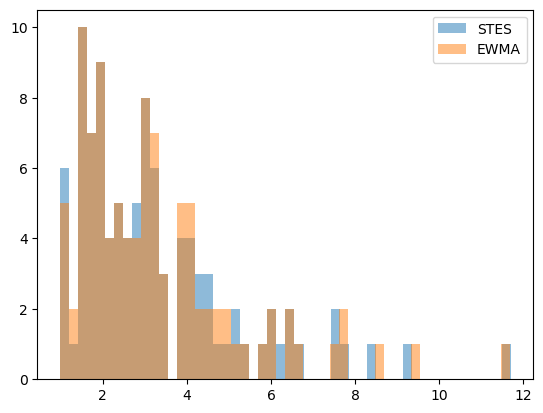

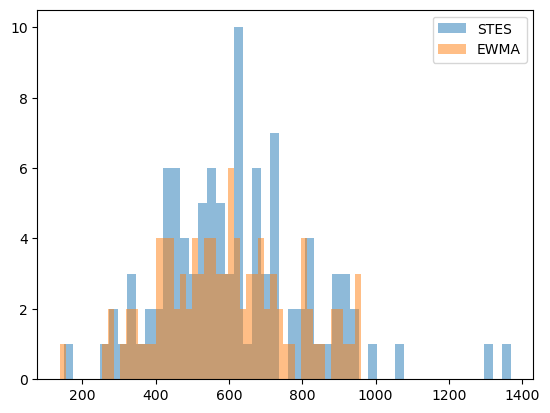

In [158]:
plt.hist(stes_os_rmses, bins=50, alpha=0.5, label='STES')
plt.hist(es_os_rmses, bins=50, alpha=0.5, label='EWMA')
plt.legend()
plt.show()

plt.hist(stes_os_llhs, bins=50, alpha=0.5, label='STES')
plt.hist(es_os_llhs, bins=50, alpha=0.5, label='EWMA')
plt.legend()
plt.show()


In [177]:
sp500_returns.dropna().index[4000:]

DatetimeIndex(['2015-11-27', '2015-11-30', '2015-12-01', '2015-12-02',
               '2015-12-03', '2015-12-04', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=2036, freq=None)

In [160]:
(
    stes_params_llh_fitted_spy, os_stes_llh_mse_spy, 
    os_stes_llh_llh_spy, llh_sigmas_spy, 
    llh_alphas_spy, is_stes_llh_mse_spy, 
    is_stes_llh_llh_spy
) = fit_stes_aese_llh(returns=sp500_returns.dropna().to_numpy(), is_index=500, os_index=4000)

print(f"""
      STES AE&SE Parameter Estimated on SPY Returns using MLE: {stes_params_llh_fitted_spy}, 
      Out-of-Sample Mean Squared Error = {os_stes_llh_mse_spy:.6f}, 
      Out-of-Sample Log-Likelihood = {os_stes_llh_llh_spy:.6f}, 
      In-Sample Mean Squared Error = {is_stes_llh_mse_spy:.6f},
      In-Sample Log-Likelihood = {is_stes_llh_llh_spy:.6f},
""")


      STES AE&SE Parameter Estimated on SPY Returns using MLE: [  -2.65905204   17.51052585 -212.4608808 ], 
      Out-of-Sample Mean Squared Error = 0.000469, 
      Out-of-Sample Log-Likelihood = -17091.456300, 
      In-Sample Mean Squared Error = 0.000517,
      In-Sample Log-Likelihood = -28926.862187,



In [161]:
(
    es_params_llh_fitted_spy, os_es_llh_mse_spy, 
    os_es_llh_llh_spy, es_llh_sigmas_spy, 
    es_llh_alphas_spy, is_es_llh_mse_spy, 
    is_es_llh_llh_spy
) = fit_es_rmse(returns=sp500_returns.dropna().to_numpy(), is_index=500, os_index=4000)

print(f"""
      ES Parameter Estimated on SPY Returns using MLE: {es_params_llh_fitted_spy}, 
      Out-of-Sample Mean Squared Error = {os_es_llh_mse_spy:.6f}, 
      Out-of-Sample Log-Likelihood = {os_es_llh_llh_spy:.6f}, 
      In-Sample Mean Squared Error = {is_es_llh_mse_spy:.6f},
      In-Sample Log-Likelihood = {is_es_llh_llh_spy:.6f},
""")


      ES Parameter Estimated on SPY Returns using MLE: [-1.20329474], 
      Out-of-Sample Mean Squared Error = 0.000445, 
      Out-of-Sample Log-Likelihood = -16882.655789, 
      In-Sample Mean Squared Error = 0.000529,
      In-Sample Log-Likelihood = -28450.456228,

